# Z-probing

With PyLabRobot, one can probe the surface of any object on a STAR(let) deck. This effectively makes the STAR act as a [Coordinate-Measurement Machine (CMM)](https://en.wikipedia.org/wiki/Coordinate-measuring_machine).

There are two ways to probe the surface of an object:

- Using capacitive liquid level sensors (cLLD) to map capacitive objects.
- Moving the tip down onto an object until resistance is detected (a "controlled crash"), which works with both capacitive and non-capacitive objects.

## Example setup

In [1]:
from pylabrobot.liquid_handling import LiquidHandler, STAR
from pylabrobot.resources import STARLetDeck
from pylabrobot.resources import (
  TIP_CAR_480_A00,
  PLT_CAR_L5AC_A00,
  TIP_50ul,
  Cor_96_wellplate_360ul_Fb
)

star = STAR()
lh = LiquidHandler(backend=star, deck=STARLetDeck())
await lh.setup()

# assign a tip rack
tip_carrier = TIP_CAR_480_A00(name="tip_carrier")
tip_carrier[1] = tip_rack = TIP_50ul(name="tip_rack")
lh.deck.assign_child_resource(tip_carrier, rails=1)

# assign a plate
plt_carrier = PLT_CAR_L5AC_A00(name="plt_carrier")
plt_carrier[0] = plate = Cor_96_wellplate_360ul_Fb(name="plt")
lh.deck.assign_child_resource(plt_carrier, rails=7)

## Capacitive probing using cLLD

If you are mapping a capacitive surface, you can use the cLLD sensor to detect the surface. This is safer and more accurate than the controlled crash method.

```{warning}
For safety purposes, we recommend using Hamilton 50ul tips for mapping surfaces. These are relatively long and soft, acting as 'cushions' in case you try out faster detection speeds (not recommended). Small bends are tolerated well by the 50ul tips.
```

Introduced in [PR #69](https://github.com/PyLabRobot/pylabrobot/pull/69).

### Mapping a single point

In [2]:
await lh.pick_up_tips(tip_rack["A1"])

For more information on manually moving channels, see [Manually moving channels around](../moving-channels-around.ipynb).

In [3]:
await star.prepare_for_manual_channel_operation(0)

In [4]:
# TODO: change this to a position that works for you
await star.move_channel_x(0, 260)
await star.move_channel_y(0, 190)

Use `STARBackend.probe_z_height_using_channel` to probe the z-height of a single point at the current location. This function will slowly lower the channel until the liquid level sensor detects a change in capacitance. The z-height of the point of the tip is then returned.

In [ ]:
await star.clld_probe_z_height_using_channel(0, move_channels_to_save_pos_after=True)

186.0

In [ ]:
await lh.return_tips()

(mapping-a-3d-surface)=
### Mapping a 3D surface

In [ ]:
await lh.pick_up_tips(tip_rack["A1"])
await star.prepare_for_manual_channel_operation(0)

In [ ]:
xs = [260 + i * 3 for i in range(13)]  # in mm, absolute coordinates
ys = [190 + i * 3 for i in range(10)]  # in mm, absolute coordinates

data = []

for x in xs:
  await star.move_channel_x(0, x)
  for y in ys:
    await star.move_channel_y(0, y)
    height = await star.clld_probe_z_height_using_channel(0, start_pos_search=25000)
    data.append((x, y, height))
    await lh.move_channel_z(0, 230)  # move up slightly for traversal

In [ ]:
await lh.return_tips()

Plotting requires `matplotlib` and `numpy`. If you don't have them installed, you can install them with `pip install matplotlib numpy`.

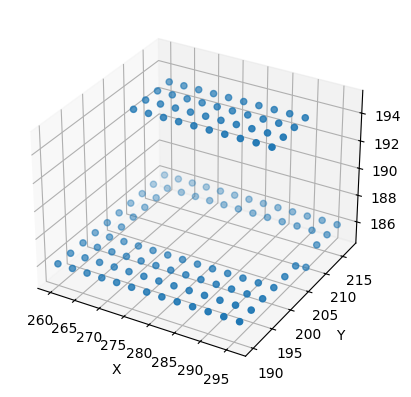

In [25]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array(data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

Check out the following video demo of mapping a 3D surface:

<iframe width="640" height="360" src="https://www.youtube.com/embed/_uPf9hyTBog" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Non-capacitive probing using the force sensor

This uses moves a tip down slowly until resistance is detected (a "controlled crash"), to measure the surface z-height. This technique is similar to what is routinely used for discarding tips into the trash in both VENUS and PLR.

Sensor accuracy for z-height readings needs to be further tested but in initial tests has been at least 0.2 mm.

### Using teaching needles

Most STAR(let)s come with a teaching block that includes 8 teaching needles. These needles are equivalent to standard volume (300uL) pipette tips but are made from metal instead of plastic. This leads to more accurate results when probing surfaces.

```{warning}
When using the teaching needles, be careful not to damage the STAR(let) deck or channels. The needles are made from metal and can bend the pipetting channels more easily than soft plastic tips.
```

In [4]:
teaching_tip_rack = lh.deck.get_resource("teaching_tip_rack")
await lh.pick_up_tips(teaching_tip_rack["A2"])

Alternatively, you can use plastic tips for probing surfaces. However, these are softer and therefore less accurate than the metal teaching needles. 50uL tips are the softest and cannot be used with force z-probing.

### Moving the channel and mapping a point

See above for more information on moving channels.

```{warning}
Make sure the tip is at a safe height above the labware before moving the channel. Use `STARBackend.move_channel_z` to move the channel to a safe height.
```

In [ ]:
await star.prepare_for_manual_channel_operation(0)
await star.move_channel_x(0, 260)
await star.move_channel_y(0, 190)

In [9]:
await star.ztouch_probe_z_height_using_channel(
  channel_idx=0,
  move_channels_to_save_pos_after=True)

184.76

In [10]:
await lh.return_tips()

Check out [mapping a 3d surface](#mapping-a-3d-surface) for more information on mapping a surface.